In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
random.seed(123)
np.random.seed(123)

In [2]:
class NN():
    # Initialize all the values
    def __init__(self, X, Y, act, op_dim=2, alpha=0.000001, lam=0.00005, hidden_nodes=2):
        self.X = X
        self.Y = Y
        self.N = len(X)
        self.ip_dim = len(X[0])
        self.op_dim = op_dim
        self.alpha = alpha
        self.lam = lam
        self.hidden_nodes = hidden_nodes
        self.weights_1 = np.random.normal(0, 1, [self.ip_dim, self.hidden_nodes])
        self.bias_1 = np.zeros((1, self.hidden_nodes))
        self.weights_2= np.random.normal(0, 1, [self.hidden_nodes, self.op_dim])
        self.bias_2 = np.zeros((1, self.op_dim))
        if act == 'relu':
            self.act = self.relu
            self.derivate_act = self.drelu
        elif act == 'sig':
            self.act = self.sig
            self.derivate_act = self.dsig
        else:
            self.act = self.tan
            self.derivate_act = self.dtan
    
    # Rectifier Linear Activation
    def relu(self, x):
        return np.maximum(0, x)
    
    # Derivative of Rectifier Linear Activation
    def drelu(self, x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x
    
    # Hyperbolic Tan Activation
    def tan(self, x):
        return np.tanh(x)
    
    # Derivative of Hyperbolic Tan Activation
    def dtan(self, x):
        return 1.0 - x ** 2
    
    # Sigmoid Activation
    def sig(self, x):
        return 1.0 / (1.0 * np.exp(-x))
    
    # Derivative of Sigmoid Activation
    def dsig(self, x):
        return x * (1.0 - x)
    
    #Calculating softmax
    def softmax(self, op):
        logits_exp = np.exp(op)
        return logits_exp / np.sum(logits_exp, axis=1, keepdims=True)
    
    
    #Calculating loss
    def calcLoss(self):        
        layer1 = self.X.dot(self.weights_1) + self.bias_1
        layer1_act = self.act(layer1)
        layer2 = layer1.dot(self.weights_2) + self.bias_2
        result = self.softmax(layer2)
        
        prob = -np.log(result[range(self.N), self.Y])
        loss = np.sum(prob)
        loss += self.lam / (2 * (np.sum(self.weights_1 ** 2) + np.sum(self.weights_2 ** 2)))
        return 1./ (self.N * loss)
   
   
    #Predicting the outputs and calculating accuracy.
    def predict(self, X, y_true, lab, weights_1=None, bias_1=None, weights_2=None, bias_2=None, flag=0):
        
        if flag == 0: 
            layer1 = X.dot(self.weights_1) + self.bias_1
            layer1_act = self.act(layer1)
            layer2 = layer1.dot(self.weights_2) + self.bias_2
            result = self.softmax(layer2)
            y_pred = np.argmax(result / np.sum(result, axis=1, keepdims=True), axis = 1)
            
        else:
            layer1 = X.dot(weights_1) + bias_1
            layer1_act = self.act(layer1)
            layer2 = layer1.dot(weights_2) + bias_2
            result = self.softmax(layer2)
            y_pred = np.argmax(result / np.sum(result, axis=1, keepdims=True), axis = 1)
        
        
        
        acc = accuracy_score(y_true, y_pred)
        print("Accuracy on "+ lab,  acc)
        
        return acc
        

    # Fitting the neural network
    def fit(self, epochs=1000, printLoss=True):
        
        
        for i in range(0, epochs):
            
            ## Feed forward
            layer1 = self.X.dot(self.weights_1) + self.bias_1
            layer1_act = self.act(layer1)
            layer2 = layer1.dot(self.weights_2) + self.bias_2
            result = self.softmax(layer2)
            

            ## Backpropogation
            delta_3 = result
            delta_3[range(self.N), self.Y] -= 1

            delta_weights_2 = (layer1_act.T).dot(delta_3)
            delta_bias_2 = np.sum(delta_3, axis=0, keepdims=True)
            delta_2 = delta_3.dot(self.weights_2.T) * self.derivate_act(layer1_act)

            delta_weights_1 = (self.X.T).dot(delta_2)
            delta_bias_1 = np.sum(delta_2, axis=0)
            
            ## Regularization
            delta_weights_1 += self.lam * self.weights_1
            delta_weights_2 += self.lam * self.weights_2

            ## Update Weights
            self.weights_1 += -self.alpha * delta_weights_1
            self.bias_1 += -self.alpha * delta_bias_1
            self.weights_2 += -self.alpha * delta_weights_2
            self.bias_2 += -self.alpha * delta_bias_2

            loss = self.calcLoss()
            if i % 100 == 0 and printLoss:
                print("Iteration ", i, "Loss", loss)
        
        #Returning the learned weights, bias and the last activation.
        return self.weights_1, self.bias_1, self.weights_2, self.bias_2, result

In [3]:
# Load the dataset
data = np.loadtxt("HW5.csv", delimiter=",", skiprows=1)
X = data[:, :-1]
Y = data[:, -1].astype(int)
train_X, temp, train_Y, temp_y = train_test_split(X, Y, test_size=0.4)
valid_X, test_X, valid_Y, test_Y = train_test_split(temp, temp_y, test_size=0.5)

### Corssvalidating for Lamda with 2 neurons in hidden layer and Relu as activation

In [4]:
l = []
params = []
lams =  np.linspace(0.00005, 0.1, 10)
for lam in lams:
    nn = NN(train_X, train_Y, act= 'relu', hidden_nodes=2, lam=lam)
    w1, b1, w2, b2, result = nn.fit(printLoss = False)
    params.append([w1,b1,w2,b2])
    l.append(nn.predict(valid_X, valid_Y, 'validtion set'))


index = l.index(max(l))
final_lam = lams[index]
final_param = params[index]
print("\n\n\nBest lamda value:" , final_lam)
nn = NN(train_X, train_Y, act= 'relu', hidden_nodes=2, lam=final_lam)
_ =nn.predict(valid_X, valid_Y, 'validtion set', final_param[0],final_param[1], final_param[2],final_param[3], flag=1)
_ = nn.predict(train_X, train_Y, 'training set', final_param[0],final_param[1], final_param[2],final_param[3], flag=1)
_ = nn.predict(test_X, test_Y, 'testing set', final_param[0],final_param[1], final_param[2],final_param[3], flag=1)

Accuracy on validtion set 0.748
Accuracy on validtion set 0.756
Accuracy on validtion set 0.749
Accuracy on validtion set 0.749
Accuracy on validtion set 0.675
Accuracy on validtion set 0.631
Accuracy on validtion set 0.749
Accuracy on validtion set 0.682
Accuracy on validtion set 0.555
Accuracy on validtion set 0.673



Best lamda value: 0.011155555555555556
Accuracy on validtion set 0.756
Accuracy on training set 0.7423333333333333
Accuracy on testing set 0.751


### Corssvalidating for Lamda with 10 neurons in hidden layer and tan as activation

In [5]:
l = []
params = []
lams =  np.linspace(0.05, 0.3, 10)
for lam in lams:
    nn = NN(train_X, train_Y, act= 'relu', hidden_nodes=10, lam=lam, alpha=0.000001)
    w1, b1, w2, b2, result = nn.fit(printLoss = False, epochs=500)
    params.append([w1,b1,w2,b2])
    l.append(nn.predict(valid_X, valid_Y, 'validtion set'))


index = l.index(max(l))
final_lam = lams[index]
final_param = params[index]
print("\n\n\nBest lamda value:" , final_lam)
nn = NN(train_X, train_Y, act= 'tan', hidden_nodes=2, lam=final_lam)
_ =nn.predict(valid_X, valid_Y, 'validtion set', final_param[0],final_param[1], final_param[2],final_param[3], flag=1)
_ = nn.predict(train_X, train_Y, 'training set', final_param[0],final_param[1], final_param[2],final_param[3], flag=1)
_ = nn.predict(test_X, test_Y, 'testing set', final_param[0],final_param[1], final_param[2],final_param[3], flag=1)

Accuracy on validtion set 0.541
Accuracy on validtion set 0.483
Accuracy on validtion set 0.547
Accuracy on validtion set 0.602
Accuracy on validtion set 0.477
Accuracy on validtion set 0.557
Accuracy on validtion set 0.251
Accuracy on validtion set 0.548
Accuracy on validtion set 0.514
Accuracy on validtion set 0.711



Best lamda value: 0.3
Accuracy on validtion set 0.711
Accuracy on training set 0.6896666666666667
Accuracy on testing set 0.7


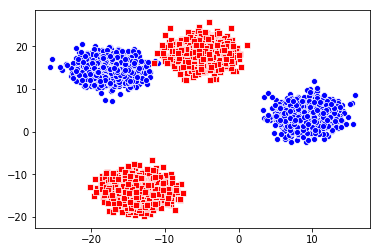

In [6]:
## Plotting the data
circle = X[np.where(Y == 1)]
square = X[np.where(Y == 0)]
sns.scatterplot(x=circle[:,0], y=circle[:, 1], color='blue', marker='o')
sns.scatterplot(x=square[:,0], y=square[:, 1], color='red', marker='s')
plt.show()

The data is not linearly seperable. 
Neither the neural net in part 2 nor part 3 was completely able to classify the data one of the reasons being the overlapping outliers which affects the decision boundry. However the neural net in part 2 and part 3 was able to classify them with a accuracy of  75% and 72% respectively.